In [ ]:
import os
import pandas as pd
import numpy as np
import re
from datetime import datetime
import pickle
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import math
from scipy.signal import find_peaks

from scipy import signal
from scipy.fftpack import fft
from scipy.signal import resample
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

def identity(x):
    return x

def safe_log(x):
    return np.log(np.clip(x, a_min=1e-6, a_max=None))

def safe_sqrt(x):
    return np.sqrt(np.clip(x, a_min=0, a_max=None))

def exp_transform(x):
    return np.exp(x)

TRANSFORMATIONS = {
    "identity": identity,
    "log": safe_log,
    "sqrt": safe_sqrt,
    "exp": exp_transform,
    # Add more as needed
}

In [ ]:
def load_dataframe_pickle(input_path):
    """
    Loads a DataFrame from a pickle file.

    :param input_path: Path to the pickle file.
    :return: Loaded Pandas DataFrame.
    """
    with open(input_path, "rb") as f:
        df = pickle.load(f)
    print(f"DataFrame loaded from Pickle: {input_path}")
    return df

def plot_force_transformation(df, transform_func, trial_index=0, transform_name="transformation"):
    original_force = np.array(df['FSR Force List'].iloc[trial_index])
    transformed_force = transform_func(original_force)
    
    plt.figure(figsize=(12, 5))
    plt.plot(original_force, label="Original Force")
    plt.plot(transformed_force, label=f"Transformed Force ({transform_name})")
    plt.title(f"Force Before and After {transform_name} (Trial {trial_index})")
    plt.xlabel("Sample Index")
    plt.ylabel("Force Value")
    plt.legend()
    plt.show()

def plot_accel_vs_force(df, transform_func, trial_index=0, transform_name="transformation"):
    accel_x = np.array(df['Accel X'].iloc[trial_index])
    original_force = np.array(df['FSR Force List'].iloc[trial_index])
    transformed_force = transform_func(original_force)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(accel_x, original_force, alpha=0.5)
    plt.title("Accel X vs. Original Force")
    plt.xlabel("Accel X")
    plt.ylabel("Force")
    
    plt.subplot(1, 2, 2)
    plt.scatter(accel_x, transformed_force, alpha=0.5, color='orange')
    plt.title(f"Accel X vs. Transformed Force ({transform_name})")
    plt.xlabel("Accel X")
    plt.ylabel("Transformed Force")
    plt.tight_layout()
    plt.show()
    
def filter_sensor_data(df, filter_type='butterworth'):
    """
    Filters accelerometer and gyroscope data using the specified filter type.

    :param df: Input DataFrame with sensor data.
    :param filter_type: Filtering method ('butterworth', 'savgol', 'std', 'hilbert', 'rectify_lowpass', 'peak_interp', 'rms', 'tkeo').
    :return: Filtered DataFrame.
    """

    if len(df) < 1:
        raise ValueError("DataFrame is empty")
    
    N = 5  # Filter order
    Fs = int(len(df['Accel X'][2]) / 5)  # Estimate sample rate assuming a 40s signal
    Wn = 0.01 * Fs  # Cutoff frequency
    
    # Design filters
    b, a = signal.butter(N, Wn, btype='low', fs=Fs)

    filtered_data = {key: [] for key in df.columns}

    factor = 0
    for i in range(len(df)):
        for key in ['Accel X', 'Accel Y', 'Accel Z', 'Gyro X', 'Gyro Y', 'Gyro Z']:
            signal_data = np.array(df[key][i])
            signal_data = np.array(signal_data, dtype=float)
            # print(signal_data[1:])

            if filter_type == 'butterworth':
                filtered_signal = signal.filtfilt(b, a, np.abs(signal_data))
                factor = 500
            elif filter_type == 'savgol':
                filtered_signal = signal.savgol_filter(signal_data, 311, 3)
                factor = 700
            elif filter_type == 'std':
                filtered_signal = pd.Series(signal_data).rolling(window=int(Fs/2)).std().fillna(0).to_numpy()
                filtered_signal = filtered_signal[int(Fs/2)+1:]  # Remove NaNs at the beginning
                factor = 500
            elif filter_type == 'hilbert':
                analytic_signal = signal.hilbert(signal_data)
                envelope = np.abs(analytic_signal)
                filtered_signal = signal.filtfilt(b, a, envelope)
                factor = 300 
            elif filter_type == 'rectify_lowpass':
                rectified = np.abs(signal_data)
                filtered_signal = signal.filtfilt(b, a, rectified)
                factor = 600
            elif filter_type == 'peak_interp':
                peaks, _ = find_peaks(np.abs(signal_data), distance=Fs//20)
                env = np.interp(np.arange(len(signal_data)), peaks, np.abs(signal_data)[peaks])
                filtered_signal = env
                factor = 500
            elif filter_type == 'rms':
                window = int(Fs / 2)
                rms = np.sqrt(pd.Series(signal_data).rolling(window).mean().fillna(0)**2)
                filtered_signal = rms.to_numpy()
                factor = 500
            elif filter_type == 'tkeo':
                x = signal_data
                tkeo_signal = np.append([0], x[1:-1]**2 - x[:-2] * x[2:])
                filtered_signal = np.sqrt(np.abs(tkeo_signal))
                factor = 500
            else:
                raise ValueError("Unsupported filter type. Choose from 'butterworth', 'savgol', 'std'.")


            filtered_data[key].append(filtered_signal * factor)

        for key in df.columns:
            if key not in ['Accel X', 'Accel Y', 'Accel Z', 'Gyro X', 'Gyro Y', 'Gyro Z']:
                filtered_data[key].append(df[key][i])
    # if filter_type == 'std' and 'FSR Force List' in df.columns:
    #     df['FSR Force List'] = df['FSR Force List'].apply(lambda x: x[int(Fs/2):])

    return upsample_force_list(pd.DataFrame(filtered_data), 'Accel X', 'FSR Force List', 'spline')

def compute_freq_amp_feature(df):
    """
    Computes spectral amplitude features from accelerometer and gyroscope data.

    :param df: Filtered DataFrame.
    :return: DataFrame with spectral amplitude features.
    """
    df_features = df.copy()
    for key in ['Accel X', 'Accel Y', 'Accel Z', 'Gyro X', 'Gyro Y', 'Gyro Z']:
        df_features[key + '_freq_amps'] = df[key].apply(lambda x: np.abs(fft(x)))
    return df_features

def concat_rows(x,y):
    """concatenate rows from dataframes to organize data for model input

    Args:
        x (_type_): _description_
        y (_type_): _description_
    """
    #final output variables
    print(f"x columns: {x.columns}")
    print(f"x in concat: {x.shape}\n")
    print(f"x length of Accel X for first index: {len(x['Accel X'].iloc[0])}")
    
    print(f"y in concat: {y.shape}\n")
    print(f"y length of FSR List: {(len(y[0]))}")

    yf= []
    xf= []
    for r in y:
            for i in r:
                yf.append(i)
    yf = np.array(yf).flatten()
    for key in x:
        temp=[]
        for r in x[key]:
            # print(f"r: {r}")
            for i in r:
                temp.append(i)
        temp=np.array(temp).flatten()
        if len(temp) != len(yf):
            #resample to adjust lengths
            x_interp = np.linspace(0, len(temp), len(yf))
            x_0 = np.linspace(0, len(temp), len(temp))
            temp = np.interp(x_interp, x_0, temp)
        xf.append(temp)
    
    xf = np.transpose(xf)
    xf,yf=arrayShuffle(xf,yf)

    print(f"xf shape: {xf.shape}")
    print(f"yf shape: {yf.shape}")
    return xf, yf

def arrayShuffle(arr1, arr2):
    # print(len(arr1), len(arr2))
    assert len(arr1) == len(arr2)
    p = np.random.permutation(len(arr1))
    return arr1[p], arr2[p]

def extract_sensor_data(row):
    """
    Convert a selected row of a DataFrame into a NumPy array of shape (len(data), 6).
    
    Args:
        row (pd.Series): A row from the DataFrame containing accelX, accelY, accelZ, gyroX, gyroY, gyroZ.
    
    Returns:
        np.ndarray: A NumPy array of shape (len(data), 6).
    """
    columns = ['Accel X', 'Accel Y', 'Accel Z', 'Gyro X', 'Gyro Y', 'Gyro Z']
    
    # Ensure all selected columns exist and have lists of the same length
    data_length = len(row[columns[0]])  # Assume all columns have the same length
    
    # Stack columns into a NumPy array of shape (len(data), 6)
    sensor_array = np.column_stack([np.array(row[col]) for col in columns])

    return sensor_array

def train_force_model(df, test_size=0.1, filter_type='butterworth', model_type='LR', visualize=False, use_cv=False):
    """
    Trains a model to predict force from accelerometer and gyroscope signals.

    :param df: Input DataFrame.
    :param test_size: Fraction of data for testing.
    :param filter_type: Type of filter ('butterworth', 'savgol', 'std').
    :param model_type: Model type ('LR' for Linear Regression, 'NN' for Neural Network).
    :param visualize: Whether to plot results.
    :return: Trained model and test results.
    """
    
    X = df[['Accel X']]
    Y = df['FSR Force List']

    # Flatten time series into single samples
    X_all, Y_all = concat_rows(X, Y)
    all_force_vals = np.concatenate(Y.values)
    print(f"X_all shape: {X_all.shape}, Y_all shape: {Y_all.shape}")

    # X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=1)
    X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=test_size, random_state=1)

    # Evaluate Dimension
    print(f"*****")
    print(f"X_train: {X_train.shape}")
    print(f"X_test: {X_test.shape}")
    print(f"Y_train: {Y_train.shape}")
    print(f"X_test: {Y_test.shape}")

    # Step 4: Train model
    if model_type == 'NN':
        model = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 10, 5), random_state=1, max_iter=9000)
    elif model_type == 'LASSO':
        model = LassoCV(cv=5, random_state=1)
    elif model_type == 'Ridge':
        model = RidgeCV()
    elif model_type == 'RF':
        # model = RandomForestRegressor(n_estimators=100, random_state=1)
        model = RandomForestRegressor(
            n_estimators=200,
            max_depth=6,
            min_samples_split=5,
            min_samples_leaf=10,
            random_state=1
        )
    else:
        model = LinearRegression()


    # best_rf_model = hyperparameter_tune_rf(X_all, Y_all)
    # trained_rfmodel = evaluate_model_with_baseline(best_rf_model, X_all, Y_all, all_force_vals)
    trained_model = evaluate_model_with_baseline(model, X_all, Y_all, all_force_vals)
    
    # print(f"***** Train Set *****")
    # X_train, Y_train = concat_rows(X_train,Y_train)
    # print(f"***** Test Set *****")
    # X_test, Y_test = concat_rows(X_test,Y_test)

    # print(f"X_train flattened shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
    # print(f"X_test flattened shape: {X_test.shape}, Y_test shape: {Y_test.shape}")
    
    model.fit(X_train, Y_train)

    # Step 5: Evaluate model
    yhat_train = model.predict(X_train)
    yhat_test = model.predict(X_test)

    train_mae = np.mean(np.abs(yhat_train - Y_train))
    test_mae = np.mean(np.abs(yhat_test - Y_test))

    print(f'Train MAE: {train_mae:.4f}')
    print(f'Test MAE: {test_mae:.4f}')

    errors_train = yhat_train - Y_train
    errors_test = yhat_test - Y_test

    plt.hist(errors_train, bins=50, alpha=0.5, label='Train')
    plt.hist(errors_test, bins=50, alpha=0.5, label='Test')
    plt.legend()
    plt.title("Error Distribution")
    plt.show()
    
    # return model, yhat_test, Y_test
    return trained_model, model, yhat_test, Y_test

def evaluate_model_with_baseline(model, X_all, Y_all, force_values, fit_final_model=True):
    """
    Evaluate regression model with 5-fold CV and compare to dummy baseline.

    Args:
        model: sklearn regression model instance (not yet fitted)
        X_all: numpy array, shape (n_samples, n_features)
        Y_all: numpy array, shape (n_samples,)
        force_values: full array of all force values (to get range)
        fit_final_model: bool, whether to fit model on all data at the end

    Returns:
        trained_model or None if fit_final_model=False
    """
    print(f"*****\nRunning 5-fold cross-validation for {model.__class__.__name__}...")
    mae_scores = cross_val_score(
        model, X_all, Y_all,
        scoring='neg_mean_absolute_error',
        cv=5
    )
    mae_scores_pos = -mae_scores

    # Dummy baseline
    dummy = DummyRegressor(strategy='mean')
    baseline_scores = cross_val_score(
        dummy, X_all, Y_all,
        scoring='neg_mean_absolute_error',
        cv=5
    )
    baseline_mae = -np.mean(baseline_scores)

    force_min, force_max = np.min(force_values), np.max(force_values)
    force_range = force_max - force_min
    mean_mae = np.mean(mae_scores_pos)
    std_mae = np.std(mae_scores_pos)
    rel_error = mean_mae / force_range * 100

    print(f"Force range: {force_min:.1f} to {force_max:.1f} ({force_range:.1f} units)")
    print(f"Baseline Dummy MAE: {baseline_mae:.2f}")
    print(f"{model.__class__.__name__} Cross-Validated MAE (5 folds): {mean_mae:.2f} ± {std_mae:.2f}")
    print(f"Relative MAE: {rel_error:.2f}% of force range")
    print(f"Fold MAEs: {mae_scores_pos}")

    if fit_final_model:
        print("Fitting final model on entire dataset...\n*****")
        model.fit(X_all, Y_all)
        return model
    else:
        return None
    
def hyperparameter_tune_rf(X_all, Y_all):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 20, None],
        'min_samples_leaf': [1, 5, 10],
        'min_samples_split': [2, 5, 10],
        'max_features': ['auto', 'sqrt', 'log2']
    }

    rf = RandomForestRegressor(random_state=1)

    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=-1,
        verbose=2
    )

    grid_search.fit(X_all, Y_all)

    print(f"Best params: {grid_search.best_params_}")
    print(f"Best CV MAE: {-grid_search.best_score_:.4f}")

    return grid_search.best_estimator_

def align_by_autocorrelation(df, measured_col='Accel Z', ground_truth_col='FSR Force List'):
    """
    Aligns the measured time series to the ground truth using cross-correlation.

    Parameters:
        df (pd.DataFrame): DataFrame containing time series columns as lists or np.arrays.
        measured_col (str): Column name for the measured time series.
        ground_truth_col (str): Column name for the ground truth time series.

    Returns:
        pd.DataFrame: DataFrame with aligned time series.
    """
    for i in range(len(df)):
        df.iloc[i] = align_row_by_autocorrelation(df.iloc[i])
    return df
    # aligned_rows = [align_row_by_autocorrelation(row) for _, row in df.iterrows()]
    # return pd.DataFrame(aligned_rows)

def align_row_by_autocorrelation(row):
    """
    Aligns the measured time series to the ground truth using cross-correlation for one row.

    Parameters:
        row (pd.Series): A row with time series data as lists or np.arrays.

    Returns:
        pd.Series: Aligned row with the same structure but trimmed values.
    """
    measured = np.asarray(row['Accel Z']) * 25
    ground_truth = np.asarray(row['FSR Force List'])

    # Cross-correlation

    measure = measured - np.mean(measured)
    ground = ground_truth - np.mean(ground_truth)
    correlation = np.correlate(measure,
                               ground,
                               mode='full')
    lags = np.arange(-len(measured) + 1, len(ground_truth))
    best_lag = lags[np.argmax(correlation)]

    # Align each time series in place
    aligned_row = row.copy()
    signal_keys = ['Accel X', 'Accel Y', 'Accel Z', 'Gyro X', 'Gyro Y', 'Gyro Z']

    if best_lag > 0:
        for key in signal_keys:
            aligned_row[key] = row[key][best_lag:]
        aligned_row['FSR Force List'] = row['FSR Force List'][:len(aligned_row['Accel Z'])]
    elif best_lag < 0:
        for key in signal_keys:
            aligned_row[key] = row[key][:best_lag]
        aligned_row['FSR Force List'] = row['FSR Force List'][-best_lag:]
    else:
        # No alignment needed
        pass

    return aligned_row

def align_measures_by_autocorrelation(measured, ground_truth):
    """
    Aligns the measured time series to the ground truth using cross-correlation.

    Parameters:
        measured (np.ndarray): The time series to be aligned.
        ground_truth (np.ndarray): The reference time series (ground truth).

    Returns:
        aligned_measured (np.ndarray): The aligned version of `measured`.
        aligned_ground_truth (np.ndarray): Trimmed ground truth (same length as aligned_measured).
        lag (int): The lag applied to align measured to ground_truth.
    """
    measured = np.asarray(measured)
    ground_truth = np.asarray(ground_truth)

    # Compute cross-correlation
    correlation = np.correlate(measured - np.mean(measured),
                               ground_truth - np.mean(ground_truth),
                               mode='full')

    # Compute lag (offset)
    lags = np.arange(-len(measured) + 1, len(ground_truth))
    best_lag = lags[np.argmax(correlation)]

    # Align the time series
    if best_lag > 0:
        aligned_measured = measured[best_lag:]
        aligned_ground_truth = ground_truth[:len(aligned_measured)]
    elif best_lag < 0:
        aligned_ground_truth = ground_truth[-best_lag:]
        aligned_measured = measured[:len(aligned_ground_truth)]
    else:
        aligned_measured = measured
        aligned_ground_truth = ground_truth

    return aligned_measured, aligned_ground_truth, best_lag

def percentile(data, x):
    """
    Compute the x-th percentile of a list of numbers.

    Parameters:
    - data: List of numbers
    - x: Percentile (between 0 and 100)

    Returns:
    - The x-th percentile value
    """

    data_sorted = sorted(data)

    print(f"data_sorted: {data_sorted}")
    print(f"length: {len(data_sorted)}")
    # k is the length of percentile; f is the integer of the quantity
    k = (len(data_sorted) - 1) * (x / 100)
    f = int(k)
    c = k - f

    print(f"each variable: f = {f}, k = {k}, c = {c}")
    
    if f + 1 < len(data_sorted):
        return data_sorted[f] + (data_sorted[f + 1] - data_sorted[f]) * c
    else:
        return data_sorted[f]
    
def convert_to_relative(df):
    """
    Convert the FSR Force List to relative values.

    Parameters:
    - df: DataFrame containing the FSR Force List

    Returns:
    - DataFrame with the FSR Force List converted to relative values
    """
    for i in range(len(df)):
        print(f"index = {i}")
        arr = np.array(df.iloc[i]['FSR Force List'])
        print(f"array: {df.iloc[i]['FSR Force List']}")
        print(f"array: {np.array(df.iloc[i]['FSR Force List'])}")
        percent = percentile(np.array(df.iloc[i]['FSR Force List']), 5)
        df.iloc[i]['FSR Force List'] = arr - percent
    return df

def normalize_data(df):
    """
    Normalize the data in the DataFrame.

    Parameters:
    - df: DataFrame containing the data to be normalized

    Returns:
    - Normalized DataFrame
    """
    for key in ['Accel X', 'Accel Y', 'Accel Z', 'Gyro X', 'Gyro Y', 'Gyro Z']:
        for i in range(len(df)):
            df.iloc[i][key] = (np.array(df.iloc[i][key]) - np.mean(np.array(df.iloc[i][key]))) / np.std(np.array(df.iloc[i][key]))
    return df

def LR_pred(intercept, coefs, df, keys=['Accel X', 'Accel Y', 'Accel Z', 'Gyro X', 'Gyro Y', 'Gyro Z']):
    """
    Predict the output using linear regression coefficients.

    Parameters:
    - intercept: Intercept of the linear regression model
    - coefs: Coefficients of the linear regression model
    - df: DataFrame containing the input data

    Returns:
    - Predicted output
    """
    X = df[keys]
    yhat = intercept + np.dot(X, coefs)
    return yhat

def upsample_force(force_array, target_len):
    original_len = len(force_array)
    x_original = np.linspace(0, 1, original_len)
    x_target = np.linspace(0, 1, target_len)

    interpolator = interp1d(x_original, force_array, kind='linear')
    return interpolator(x_target)

def upsample_force_list(df, sensor_ref_col='Accel X', force_col='FSR Force List', method='linear'):
    """
    Upsample the FSR force list to match the length of the reference sensor signal for each row.

    Args:
        df (pd.DataFrame): DataFrame with time-series data per row.
        sensor_ref_col (str): Column name of the sensor used as the reference for target length.
        force_col (str): Column name of the force list to be upsampled.
        method (str): Interpolation method ('linear' or 'spline').

    Returns:
        pd.DataFrame: Modified DataFrame with upsampled force lists.
    """
    df_upsampled = df.copy()

    for idx in df.index:
        sensor_len = len(df.at[idx, sensor_ref_col])
        force_vals = df.at[idx, force_col]

        if not isinstance(force_vals, (list, np.ndarray)) or len(force_vals) < 2:
            df_upsampled.at[idx, force_col] = [0.0] * sensor_len
            continue

        x_old = np.linspace(0, 1, len(force_vals))
        x_new = np.linspace(0, 1, sensor_len)

        try:
            if method == 'spline':
                interpolator = interp1d(x_old, force_vals, kind='cubic', fill_value="extrapolate")
                upsampled_force = interpolator(x_new)
            else:  # default to linear
                upsampled_force = np.interp(x_new, x_old, force_vals)

            df_upsampled.at[idx, force_col] = upsampled_force.tolist()

        except Exception as e:
            print(f"[Warning] Upsampling failed at index {idx}: {e}")
            df_upsampled.at[idx, force_col] = [0.0] * sensor_len

    return df_upsampled

def predict_force(df, intercept=15.5, coefs=[7.11570878, 2.45403903], keys=['Accel Z', 'Gyro Y']):

    """
    Predict the force using the trained model.

    Parameters:
    - df: DataFrame containing the input data
    - intercept: Trained model intercept
    - coefs: Trained model coefficients
    - keys: List of keys to be used for prediction

    Returns:
    - DataFrame with a new column 'Predicted Force'
    """

    predicted_forces = []
    max_forces = []

    for i in range(len(df)):
        len_0 = len(df.at[i, keys[0]])
        len_1 = len(df.at[i, keys[1]])

        if len_0 != len_1:
            min_len = min(len_0, len_1)
            df.at[i, keys[0]] = df.at[i, keys[0]][:min_len]
            df.at[i, keys[1]] = df.at[i, keys[1]][:min_len]
            
        pred = LR_pred(intercept, coefs, df.iloc[i], keys)
        predicted_forces.append(pred)
        max_forces.append(percentile(np.float64(pred), 95))

    df['Predicted Force'] = predicted_forces
    df['Max Force'] = max_forces
    
    return df

def compare_data(df, filtered_df, number_of_index, set_to_drop=None):
    if set_to_drop is None:
        set_to_drop = []

    # Generate list of indices to plot, skipping dropped ones
    all_indices = list(range(len(df)))
    available_indices = [i for i in all_indices if i not in set_to_drop]
    indices_to_plot = available_indices[:number_of_index]

    # Set up figure: 2 rows (Force + Filtered Accel X on top, Raw Accel X on bottom)
    fig, axes = plt.subplots(
        nrows=2,
        ncols=len(indices_to_plot),
        figsize=(len(indices_to_plot) * 5, 10),  # Keep square shape
        sharex=False
    )

    for col, index in enumerate(indices_to_plot):
        # Get data
        force_data = df['FSR Force List'][index]
        accel_x_data = df['Accel X'][index]
        filtered_accel_x_data = filtered_df['Accel X'][index]

        # Time axes
        t_force = np.linspace(0, 10, len(force_data))
        t_accel = np.linspace(0, 10, len(accel_x_data))
        t_filtered = np.linspace(0, 10, len(filtered_accel_x_data))

        # Plot Force and Filtered Accel X on top row
        axes[0, col].plot(t_force, force_data, color='blue', label='Force')
        axes[0, col].plot(t_filtered, filtered_accel_x_data, color='green', label='Filtered Accel X')
        axes[0, col].set_ylim(0, 800)
        axes[0, col].set_title(f"Set {index}")
        axes[0, col].set_xlabel("Time (s)")
        axes[0, col].set_aspect('auto')
        if col == 0:
            axes[0, col].set_ylabel("Force / Filtered Accel X")
        axes[0, col].legend(loc="upper right")

        # Plot Raw Accel X on bottom row
        axes[1, col].plot(t_accel, accel_x_data, color='orange')
        axes[1, col].set_ylim(-4, 4)
        axes[1, col].set_xlabel("Time (s)")
        axes[1, col].set_aspect('auto')
        if col == 0:
            axes[1, col].set_ylabel("Accel X (raw)")

    plt.tight_layout()
    plt.suptitle("Force, Raw Accel X, Filtered Accel X (Excluding Dropped Sets)", fontsize=16, y=1.05)
    plt.subplots_adjust(top=0.90)
    plt.show()
    


In [591]:
trial = 3
file = f"fullgrip_data_{trial}.pkl"
input_directory = "experiment3"

df1 = load_dataframe_pickle(f"{input_directory}/{file}")

file1 = f"fullgrip_data_exp2_2.pkl"
df2 = load_dataframe_pickle(f"experiment2/{file1}")

df = pd.concat([df1, df2], axis=0).reset_index(drop=True)


DataFrame loaded from Pickle: experiment3/fullgrip_data_3.pkl
DataFrame loaded from Pickle: experiment2/fullgrip_data_exp2_2.pkl


In [731]:
df.rename(columns={
    'accelX': 'Accel X',
    'accelY': 'Accel Y',
    'accelZ': 'Accel Z',
    'gyroX': 'Gyro X',
    'gyroY': 'Gyro Y', 
    'gyroZ': 'Gyro Z'}, inplace=True)
df.shape

(41, 15)

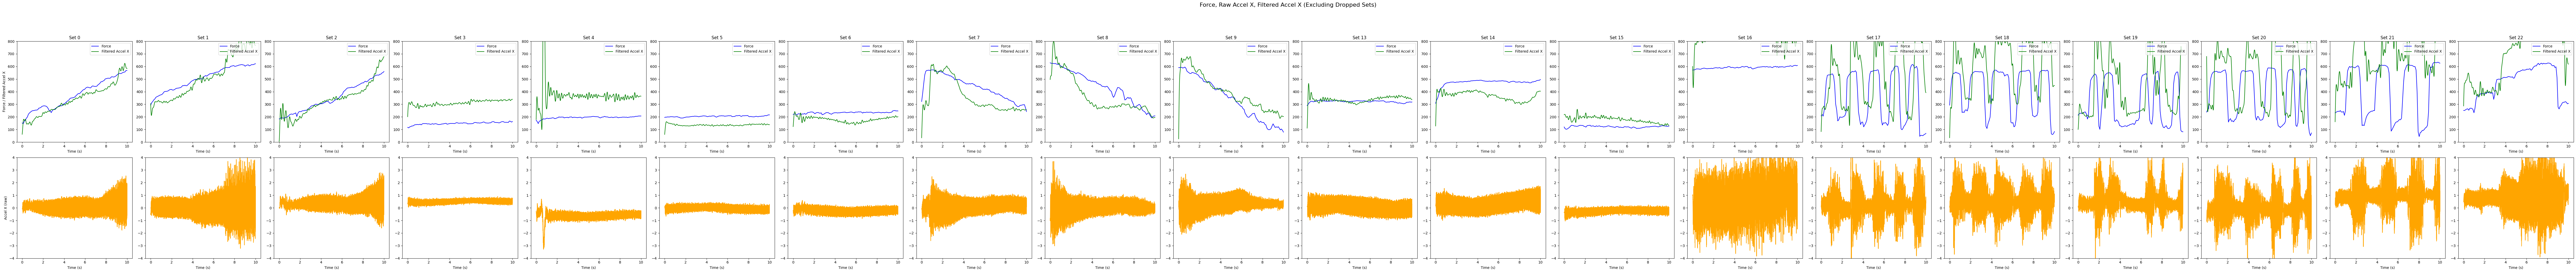

In [823]:
set_to_drop = [10, 11, 12]
# 'butterworth', 'savgol', 'std', 'hilbert', 'rectify_lowpass', 'peak_interp', 'rms', 'tkeo'
filtered_df = filter_sensor_data(df, 'rectify_lowpass')
compare_data(df, filtered_df, 20, set_to_drop)

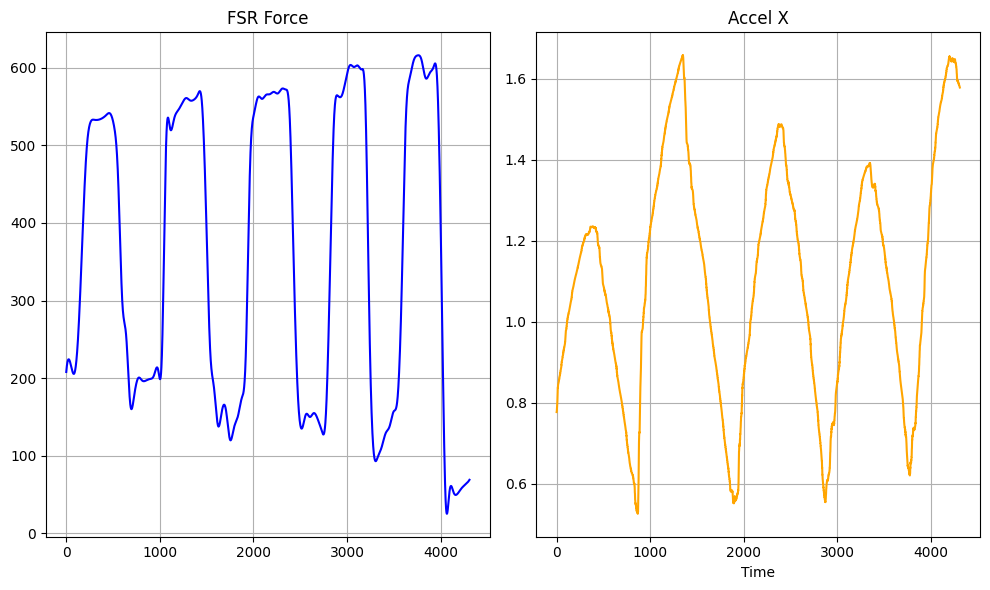

In [703]:
df_to_plot = filter_sensor_data(df, 'std')

index = 17

fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharex=True)

axs[0].plot(df_to_plot['FSR Force List'].iloc[index], color='blue')
axs[0].set_title('FSR Force')
axs[0].grid(True)

axs[1].plot(df_to_plot['Accel X'].iloc[index], color='orange')
axs[1].set_title('Accel X')
axs[1].grid(True)

plt.xlabel('Time')
plt.tight_layout()
plt.show()


/var/folders/05/dr89ndl917s54hd7ccfqgcrw0000gn/T/ipykernel_45645/1462101758.py:459: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[i][key] = (np.array(df.iloc[i][key]) - np.mean(np.array(df.iloc[i][key]))) / np.std(np.array(df.iloc[i][key]))


Training with: (22, 15)
x columns: Index(['Accel X'], dtype='object')
x in concat: (22, 1)

x length of Accel X for first index: 4321
y in concat: (22,)

y length of FSR List: 4321
xf shape: (68890, 1)
yf shape: (68890,)
X_all shape: (68890, 1), Y_all shape: (68890,)
*****
X_train: (55112, 1)
X_test: (13778, 1)
Y_train: (55112,)
X_test: (13778,)
*****
Running 5-fold cross-validation for LinearRegression...
Force range: 55.6 to 642.1 (586.4 units)
Baseline Dummy MAE: 139.08
LinearRegression Cross-Validated MAE (5 folds): 66.90 ± 0.19
Relative MAE: 11.41% of force range
Fold MAEs: [66.83845605 66.66947651 67.24586348 66.94329142 66.80362492]
Fitting final model on entire dataset...
*****
Train MAE: 66.9053
Test MAE: 66.6085


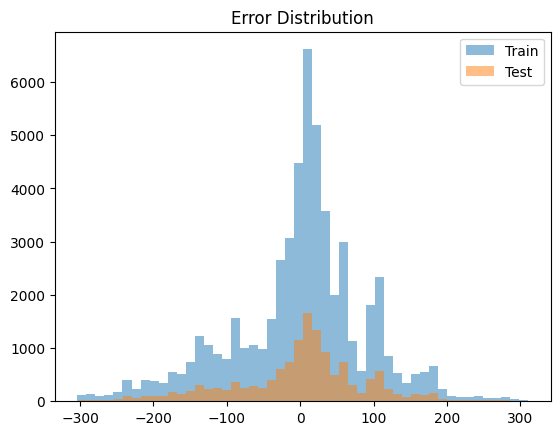

In [712]:
df_filtered = filter_sensor_data(df, 'std')

rows_to_drop = [27, 29, 36, 38, 40]
set_to_drop = [27, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
set_to_drop1 = [11, 12, 17, 18, 19, 20, 21, 27, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
set_to_drop2 = [11, 12, 17, 18, 19, 20, 21, 27, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


df_dropped = df_filtered.drop(index=set_to_drop1).reset_index(drop=True)

df_normalized = normalize_data(df_dropped)
df_aligned = align_by_autocorrelation(df_normalized)
# df_aligned

# print(df_filtered['FSR Force List'])

# X = df_filtered[['Accel X', 'Accel Z', 'Gyro X', 'Gyro Y', 'Gyro Z']]
# Y = df_filtered['FSR Force List']

# Flatten time series into single samples
# print(len(df_filtered['FSR Force List'].iloc[0]))
# X_all, Y_all = concat_rows(X, Y)
# newY = upsample_force_list(df_filtered, 'Accel X', 'FSR Force List', 'spline')
# print(len(newY['FSR Force List'].iloc[0]))

# fiveFoldModel, model, preds, truth_vals = train_force_model(df_filtered, test_size=0.2, filter_type='std', model_type='RF', visualize=True, use_cv=True)
print(f"Training with: {df_aligned.shape}")
fiveFoldModel, model, preds, truth_vals = train_force_model(df_aligned, test_size=0.2, filter_type='std', model_type='LR', visualize=True, use_cv=True)



Project Name                                        VibroDataCollection
Phone Model                                                        c4a0
Participant ID                                                      gi1
Timestamp                                    2025-07-15 13:43:27.463000
Time                  [1752612207488, 1752612207488, 1752612207488, ...
Accel X               [-0.08135597, -0.086141616, -0.086141616, -0.0...
Accel Y               [9.456435, 9.446864, 9.466006, 9.475577, 9.489...
Accel Z               [1.3495519, 1.3734802, 1.3830515, 1.3974084, 1...
Gyro X                [0.26480988, 0.1915061, 0.18661919, 0.18173227...
Gyro Y                [-0.113926284, -0.025961753, -0.017409647, -0....
Gyro Z                [0.0097738365, 0.045203995, 0.050090913, 0.054...
FSR TimeDiff List     [0.0, 0.025571, 0.081838, 0.147866, 0.260974, ...
FSR Timestamp List    [2025_07_15_13_43_27_599969, 2025_07_15_13_43_...
FSR Force List        [152.0, 145.0, 165.0, 173.0, 189.0, 199.0,

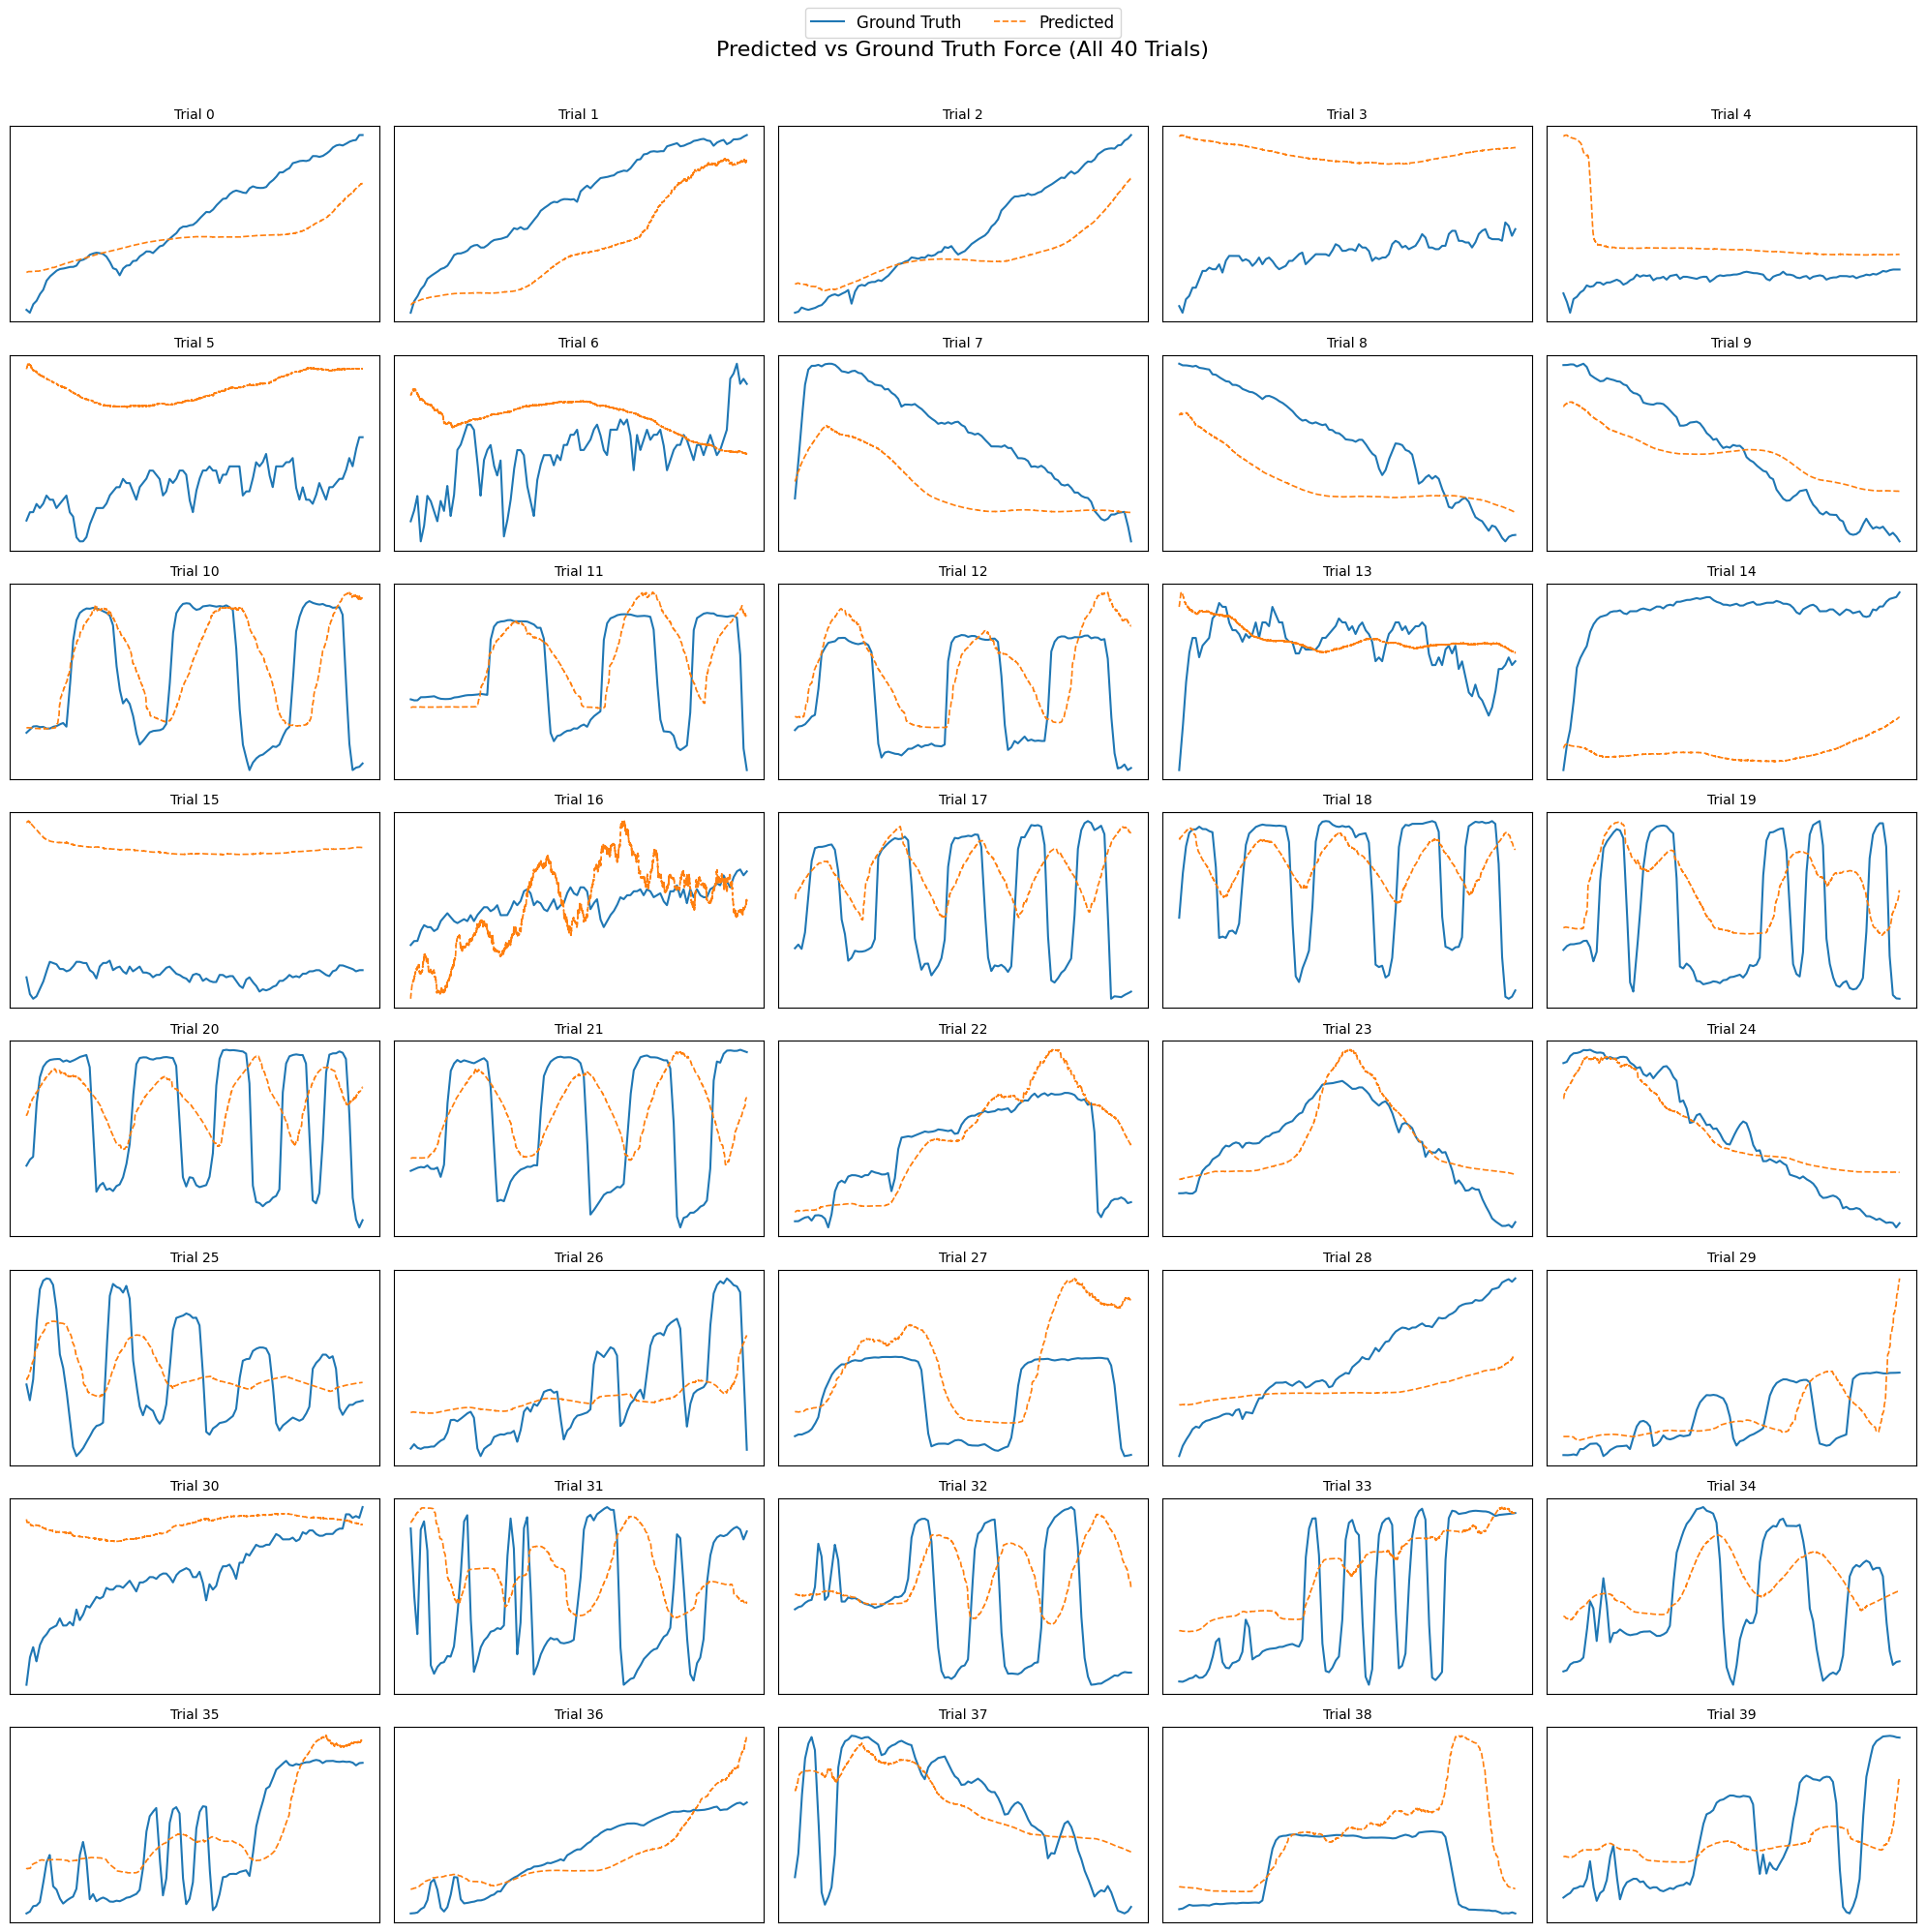

In [710]:

fig, axes = plt.subplots(nrows=8, ncols=5, figsize=(20, 20))
axes = axes.flatten()

for idx in range(40):
    trial = df.iloc[idx]
    filtered = filter_sensor_data(df, 'std')


    print(trial)

    print(f"size of FSR is {len(trial['FSR Force List'])} and size of sensor samples are {len(trial['Accel X'])}")
        
    # min_len = len(filtered['Accel X'][idx])

    # print(f"min length is {min_len}")
    # X_input = np.stack([
    #     filtered['Accel X'][idx][:min_len]
    # ], axis=1)

    X_input = np.array(filtered['Accel X'][idx]).reshape(-1, 1)
    predicted_force = model.predict(X_input)
    # predicted_force = fiveFoldModel.predict(X_input)

    ground_truth_force = trial['FSR Force List']
    upsampled_force = upsample_force(ground_truth_force, len(predicted_force))

    ax = axes[idx]
    ax.plot(upsampled_force, label='Ground Truth', linewidth=1.5)
    ax.plot(predicted_force, label='Predicted', linestyle='--', linewidth=1.2)
    ax.set_title(f'Trial {idx}', fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

# Global legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=12)

plt.suptitle("Predicted vs Ground Truth Force (All 40 Trials)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # leave space for suptitle
plt.show()

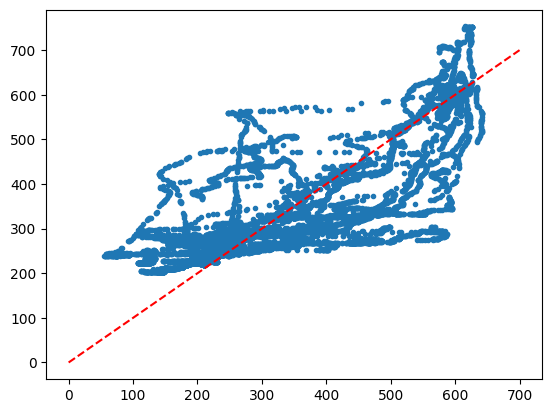

In [711]:
plt.plot(truth_vals, preds, '.')
plt.plot([0, 700], [0, 700], 'r--', label='Perfect Prediction')
